In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
import os

# This checks if the data is where we think it is
print(os.listdir('/kaggle/input/flowers-recognition/flowers'))

2025-12-17 20:14:14.049973: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766002454.383571      56 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766002454.475858      56 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766002455.282617      56 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766002455.282675      56 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766002455.282678      56 computation_placer.cc:177] computation placer alr

['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']


In [2]:
DATA_DIR = '/kaggle/input/flowers-recognition/flowers'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Prepare the data
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    horizontal_flip=True
)

# Load Training Data
train_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Load Validation Data
val_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 3457 images belonging to 5 classes.
Found 860 images belonging to 5 classes.


In [3]:
# --- Step 1: Setup Data Loading ---
DATA_DIR = '/kaggle/input/flowers-recognition/flowers'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Create image generator (scales numbers to 0-1)
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    horizontal_flip=True
)

# Load Training Data
print("Loading Training Data...")
train_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Load Validation Data
print("Loading Validation Data...")
val_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# --- Step 2: Build & Train Custom CNN (Task A) ---
print("\nStarting Task A: Custom CNN...")

model_custom = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

model_custom.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train for 10 epochs (Adjust 'epochs' if it takes too long)
history_custom = model_custom.fit(train_generator, validation_data=val_generator, epochs=10)
print("Task A Complete!")

Loading Training Data...
Found 3457 images belonging to 5 classes.
Loading Validation Data...
Found 860 images belonging to 5 classes.

Starting Task A: Custom CNN...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-12-17 20:17:19.170956: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.3512 - loss: 1.7608 - val_accuracy: 0.5442 - val_loss: 1.1413
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.5692 - loss: 1.0431 - val_accuracy: 0.5919 - val_loss: 0.9826
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.6484 - loss: 0.9117 - val_accuracy: 0.6419 - val_loss: 0.9068
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.6853 - loss: 0.8279 - val_accuracy: 0.6244 - val_loss: 0.9187
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.7018 - loss: 0.7555 - val_accuracy: 0.6651 - val_loss: 0.8905
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.7396 - loss: 0.6880 - val_accuracy: 0.6826 - val_loss: 0.8491
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.7524 - loss: 0.6596 - val_accuracy: 0.6860 - val_loss: 0.8115
Epoch 8/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.7683 - loss: 0.6117 - val_accu

In [5]:
# --- Step 3: Build & Train Transfer Learning Model (Task B) ---
print("\nStarting Task B: Transfer Learning (MobileNetV2)...")

# Download the pre-trained brain
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False # Freeze it so we don't break what it already knows

model_transfer = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

model_transfer.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history_transfer = model_transfer.fit(train_generator, validation_data=val_generator, epochs=10)
print("Task B Complete!")


Starting Task B: Transfer Learning (MobileNetV2)...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 103s 911ms/step - accuracy: 0.7110 - loss: 0.7515 - val_accuracy: 0.8384 - val_loss: 0.4394
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 92s 839ms/step - accuracy: 0.8853 - loss: 0.3324 - val_accuracy: 0.8791 - val_loss: 0.3673
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 93s 853ms/step - accuracy: 0.8974 - loss: 0.2761 - val_accuracy: 0.8512 - val_loss: 0.4093
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 94s 863ms/step - accuracy: 0.9143 - loss: 0.2194 - val_accuracy: 0.8453 - val_loss: 0.4299
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 100s 916ms/step - accuracy: 0.9374 - loss: 0.1734 - val_accuracy: 0.8547 - val_loss: 0.4049
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 98s 895ms/step - accuracy: 0.9487 - loss: 0.1466 - val_accuracy: 0.8767 - val_loss: 0.3756
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 91s 830ms/step - accuracy: 0.9707 - loss: 0.1073 - val_accuracy: 0.881

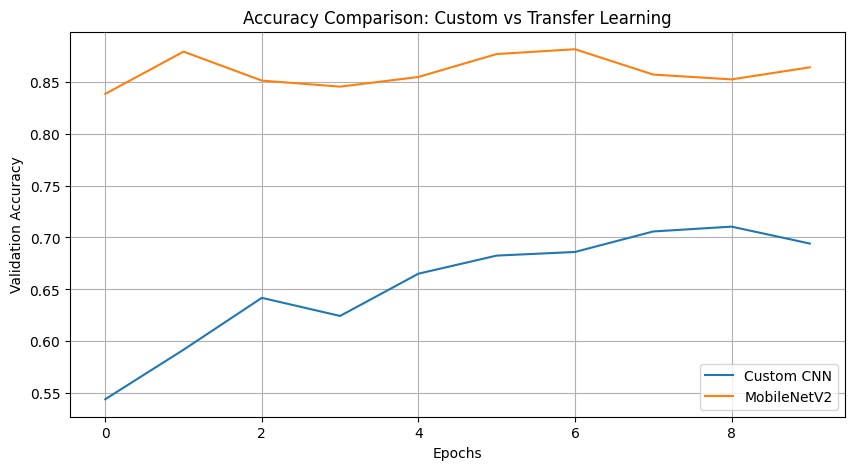

In [6]:
# --- Step 4: Comparison Graph ---
plt.figure(figsize=(10, 5))
plt.plot(history_custom.history['val_accuracy'], label='Custom CNN')
plt.plot(history_transfer.history['val_accuracy'], label='MobileNetV2')
plt.title('Accuracy Comparison: Custom vs Transfer Learning')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()